### 전처리(Preprocessing)

- Noise 및 NULL값 처리
- 데이터 인코딩(encoding)
- 스케일링 및 정규화 (Scaling/Normalization)

#### 인코딩

In [58]:
# 레이블 인코딩 : 라벨링을 매겨서 크고작음에 대한 우선순위가 발생하는 부작용, 컬럼개수가 늘지 않는것은 장점
# 회귀모델보다는 트리형태의 분류 알고리즘에 사용

from sklearn.preprocessing import LabelEncoder

items=['TV','냉장고','컴퓨터','믹서','믹서','믹서','핸드폰']
encoder = LabelEncoder()

# 피처값을 인코딩할때 fit 과 transform 을 사용 
labels = encoder.fit_transform(items)  #이렇게 한번에 쓸수도 있음 
print('인코딩 변환값:',labels)

# 인코딩 후에는 classes_ 속성값에 0부터 순서대로 저장됨 
print('인코딩 클래스:',encoder.classes_) 
print('디코딩:',encoder.inverse_transform([4,1,2]))

인코딩 변환값: [0 1 3 2 2 2 4]
인코딩 클래스: ['TV' '냉장고' '믹서' '컴퓨터' '핸드폰']
디코딩: ['핸드폰' '냉장고' '믹서']


In [59]:
# 원핫 인코딩: 가장 많이 쓰는... 
# 사이킷런의 OneHotEncoder 는 희소행렬->밀집행렬 변환과정 등 번거로움. 
# Pandas 의 get_dummies 라는 API가 가장 편함. 
import pandas as pd
import numpy as np

data = {'Age': [25, 30, 35], 'Gender': ['Male', 'Female', 'Female'], 
'City': ['Seoul', 'Busan', 'Incheon'], 'Salary': [500, 600, 550] }
df = pd.DataFrame(data)

df_onehotencoded = pd.get_dummies(df, drop_first=True) # drop_first 를 사용하면 클래스-1 개의 컬럼만 만들음. 다중 공선성 제거. 디폴트는 False
print(df_onehotencoded)

   Age  Salary  Gender_Male  City_Incheon  City_Seoul
0   25     500            1             0           1
1   30     600            0             0           0
2   35     550            0             1           0


#### 스케일링 (표준화,정규화)
- 서로다른 피쳐들의 크기 차이가 너무 크지 않도록 맞춰주는 작업
- 표준화(Standardization)은 N(0,1) 정규분포를 따르도록 조정
- 정규화(Normalization)은 모두 같은 크기로 범위로 맞춰주는 것
- 학습/테스트 데이터셋을 분리하고 스켈링하면 기준이 달라지기 때문에, split 이전에 해야함
- 회귀문제에서는 타겟의 분포가 Skewed 되어있으면 (Histogram으로 확인가능) 정규화 해줘야함. 

##### 타겟과 숫자형 피쳐들의 Skewness 구하고, log 변환으로 정규화하기

<Axes: xlabel='SalePrice', ylabel='Count'>

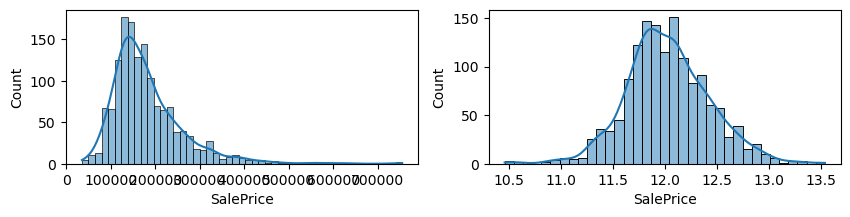

In [60]:
# 타겟값의 skew 정도를 히스토그램으로 확인 후 log변환으로 표준화 진행.
import seaborn as sns
import matplotlib.pyplot as plt


house_df = pd.read_csv('house_price.csv')

fig, axes = plt.subplots(1, 2, figsize=(10, 2))
sns.histplot(house_df['SalePrice'], kde=True, ax=axes[0])

# 로그 변환
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True, ax=axes[1])

In [61]:
# 숫자형 피쳐들의 skew 값 구하기.
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
#print(skew_features)

# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False)[:5])
 
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

MiscVal         24.451640
PoolArea        14.813135
LotArea         12.195142
3SsnPorch       10.293752
LowQualFinSF     9.002080
dtype: float64


##### 표준화와 정규화
- SVM,선형회귀,로지스틱회귀는 데이터가 정규분포를 띈다는 가정하에 구현되었기에 표준화가 매우 중요하다. 
- 대부분의 회귀문제에서는 타겟이 Skewed 되있다면 로그 정규화를 진행한다. 
- 일반적으로 선형회귀 문제는 중요한 피쳐들 + 타겟에 대해 스케일링/정규화 작업을 수행한다. 
- 스케일링으로 로그변환이 주로 사용되는 이유는, 정규분포 변환은 원본으로의 원복이 힘든 반면 로그변환은 넘파이의 log1p() 함수로 정규화 하고, 원복시에 expn1() 함수로 간단히 원상복구 할 수 있기 때문이다. 

In [63]:
# StandardScaler 를 통한 N(0,1)로의 정규화
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label']=iris.target
iris_data = iris_df.drop(columns=['label'])
iris_label = iris_df['label']

x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_label,
                                                   test_size = 0.2, random_state=11)

scaler = StandardScaler()
scaler.fit(iris_data)
# scaler 로 transform 하면 Numpy 의 ndarray 형태로 반한됨. 
iris_scaled = scaler.transform(iris_data)
iris_df_scaled = pd.DataFrame(data=iris_scaled, columns=iris.feature_names)

# print(iris_df_scaled.describe()) 으로 정규화 확인

In [65]:
# MinMaxScaler를 통한 0~1 크기로 표준화
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(iris_data)
iris_scaled=scaler.transform(iris_data)
iris_df_scaled=pd.DataFrame(data=iris_scaled, columns=iris.feature_names)
# print(iris_df_scaled.describe())

#### Oversampling & Under Sampling 
- Oversampling 과 Under Sampling 은 불균형한 데이터셋의 불균형을 완화해주는 기법이다. 
- 데이터 유실 문제로 대게의 경우에는 Oversampling 이 사용되는데, Oversampling은 적은 라벨의 데이터를 많은 라벨 수준으로 증식 시켜주는 방식이다. Oversampling 에 대표적인 방법이 SMOTE 이다. 
- SMOTE (Synthetic Minority Over-sampling Technique)의 약자로 대표적인 오버 샘플링 기법 중 하나이다.낮은 비율로 존재하는 클래스의 데이터를 최근접이웃 알고리즘알고리즘(K-NN)을 활용하여 새롭게 생성하는 방법이다.
- 가상의 데이터를 증식하는 방식이기때문에, 검증/테스트셋에는 사용하면 안되며, 학습데이터에만 사용해야한다.
- 통상적으로 Oversample 하면 재현율(Recall)은 올라가고 정밀도(Precision)은 떨어진다. 

- Data Augmentation 과의 차이? 비슷한 맥락에서 사용할 수도 있지만 Oversampling 은 불균형 데이터셋을 맞춰 적은 클래스 데이터가 학습이 안되는걸 방지하는 목적에 가깝고, Augmentation은 주로 딥러닝 모델에서 더 강력한 모델을 만들기 위해 가지고 있는 데이터를 변형시켜 증식하는 목적이다. 

In [73]:
#
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print(type(x_train_over),type(y_train_over))
print('SMOTE 적용 전 레이블 값 분포: \n', y_train.value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', y_train_over.value_counts())
# SMOTE 사용 후 Label 1에 해당하는 학습데이터가 Label 0 수준으로 증가함 확인

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (120, 4) (120,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (123, 4) (123,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
SMOTE 적용 전 레이블 값 분포: 
 0    41
1    40
2    39
Name: label, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    41
2    41
1    41
Name: label, dtype: int64
